**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


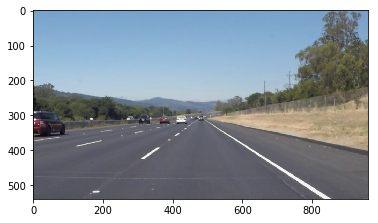

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
plt.imshow(image,cmap='gray')

## Read in an Image

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    y_min = img.shape[0]
    y_max = int(img.shape[0]*0.611) 
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)

    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < -0.5 and slope > -0.9 : # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            elif slope < 0.9 and slope > 0.5:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    slope1, intercept1 = left_lane
    slope2, intercept2 = right_lane
    
    x1 = int((y_min - intercept1)/slope1)
    x2 = int((y_max - intercept1)/slope1)
    
    cv2.line(img, (x1, y_min), (x2, y_max), color, thickness)

    x1 = int((y_min - intercept2)/slope2)
    x2 = int((y_max - intercept2)/slope2)
    cv2.line(img, (x1, y_min), (x2, y_max), color, thickness)
    print(left_lane)

#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img



# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


    

            

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

solidWhiteCurve.jpg
(540, 960, 3)


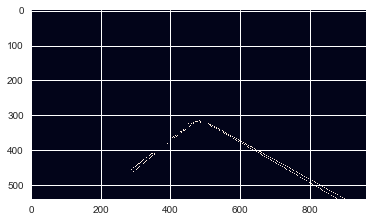

[  -0.78319124  685.64914336]


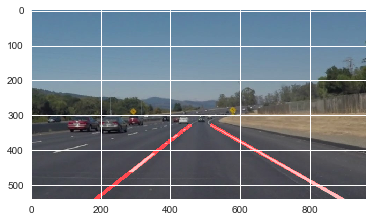

solidWhiteRight.jpg
(540, 960, 3)


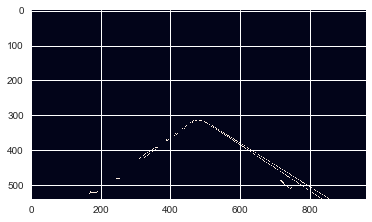

[  -0.7033457   645.18631128]


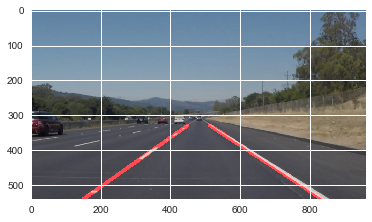

solidYellowCurve.jpg
(540, 960, 3)


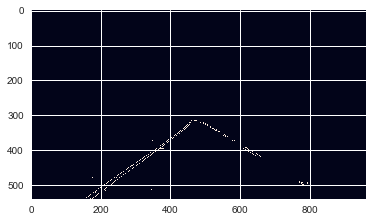

[  -0.73000878  658.41807387]


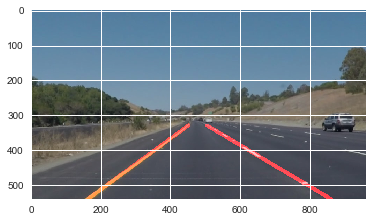

solidYellowCurve2.jpg
(540, 960, 3)


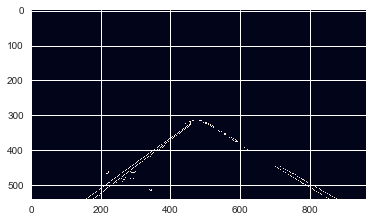

[  -0.74731562  669.31910622]


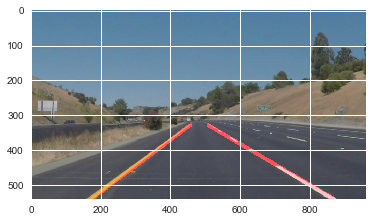

solidYellowLeft.jpg
(540, 960, 3)


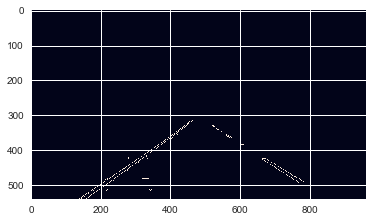

[  -0.71527576  648.58329806]


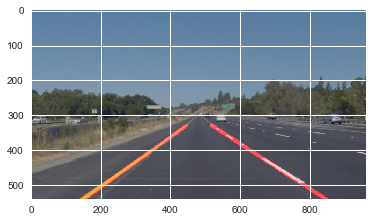

whiteCarLaneSwitch.jpg
(540, 960, 3)


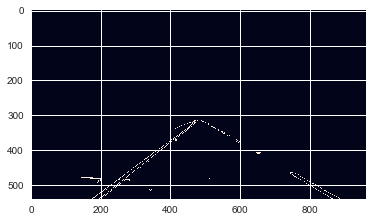

[  -0.7435509   674.29097339]


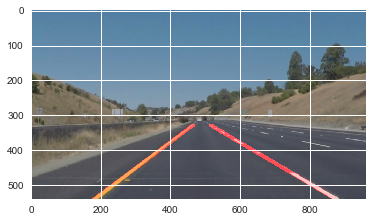

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import seaborn as sns; sns.set()
from sklearn.linear_model import LinearRegression


# adding name of the pic files into a list
pics = []
pics = os.listdir("test_images/")

#looping through each pics draw lines then show the pic
for num_pic in range(len(pics)):
    print(pics[num_pic])
    image = mpimg.imread('test_images/'+ pics[num_pic])
    #plt.imshow(image)
    #plt.show()
    
#gray the image for better edge detection
    gray = grayscale(image)
    #plt.imshow(gray, cmap='gray')
    #plt.show()
    
#using Gaussian smothing begore CAanny for lowering the noise
    kernel_size = 5
    blur_gray = gaussian_blur(image, kernel_size)
    #plt.imshow(blur_gray)
   # plt.show()

#define the parameter for Canny and run to find the edge
    low_threshold = 50
    high_threshold = 150
    
    edges = canny(image, low_threshold, high_threshold)
#     plt.imshow(edges,cmap='Greys_r')
#     plt.show()
    
#add mask as four sided polygon 
    imshape = image.shape
    print(imshape)
    vertices = np.array([[(0,imshape[0]),(460, 315), (490, 315), (imshape[1],imshape[0])]], dtype=np.int32)
    
    masked_edges = region_of_interest(edges, vertices)
    roi_images = masked_edges
    plt.imshow(masked_edges)
    plt.show()

#define the Hough transform parameter
#make the blank the same size as our image to draw on
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_length = 20
    max_line_gap = 300
#     line_image = np.copy(image)*0 #creating a blank to draw lines on
#     lines = cv2.HoughLinesP(masked_edges,rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),8)
            
    # Create a "color" binary image to combine with line image 
    color_edges = np.dstack((edges, edges, edges))

    combo = weighted_img(line_image, image, α=0.8, β=1., γ=0.)

#     plt.imshow(image)
#     plt.show()
    plt.imshow(combo)
    plt.show()
    
# then save them to the test_images_output directory.
    mpimg.imsave('output_'+ pics[num_pic], combo)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
     
    gray = grayscale(image)
    #plt.imshow(gray, cmap='gray')
    #plt.show()
    
#using Gaussian smothing begore CAanny for lowering the noise
    kernel_size = 5
    blur_gray = gaussian_blur(image, kernel_size)
    #plt.imshow(blur_gray)
   # plt.show()

#define the parameter for Canny and run to find the edge
    low_threshold = 50
    high_threshold = 150
    
    edges = canny(image, low_threshold, high_threshold)
#     plt.imshow(edges,cmap='Greys_r')
#     plt.show()
    
#add mask as four sided polygon 
    imshape = image.shape
    #vertices = np.array([[(0,imshape[0]),(460, 315), (490, 315), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[(0,imshape[0]),(400, 315), (550, 315), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
#     plt.imshow(masked_edges)
#     plt.show()



#define the Hough transform parameter
#make the blank the same size as our image to draw on
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_length = 20
    max_line_gap = 10
#     line_image = np.copy(image)*0 #creating a blank to draw lines on
#     lines = cv2.HoughLinesP(masked_edges,rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),8)
            
    # Create a "color" binary image to combine with line image 
    #color_edges = np.dstack((edges, edges, edges))

    combo = cv2.addWeighted(image, 0.8, line_image,1, 0)

    return combo


Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[  -0.7315544   655.63011197]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|                                                  | 0/222 [00:00<?, ?it/s]

[  -0.7315544   655.63011197]
[  -0.72694088  652.56972638]
[  -0.73369317  654.36168658]


  1%|▌                                         | 3/222 [00:00<00:09, 24.00it/s]

[  -0.71900631  648.88440513]
[  -0.7103278   644.91847111]
[  -0.71615709  647.43613164]


  3%|█▏                                        | 6/222 [00:00<00:08, 24.35it/s]

[  -0.68931698  636.13110476]
[  -0.7258213  651.5370651]
[  -0.7103549   645.85890633]


  4%|█▋                                        | 9/222 [00:00<00:08, 25.48it/s]

[  -0.7196793   650.20083275]
[  -0.7238127   654.96018557]
[  -0.75210327  664.57348535]


  5%|██▏                                      | 12/222 [00:00<00:07, 26.40it/s]

[  -0.72617861  653.75642007]
[  -0.70711447  643.47084967]
[  -0.71305206  644.1254278 ]


  7%|██▊                                      | 15/222 [00:00<00:07, 26.17it/s]

[  -0.69634313  635.88142716]
[  -0.70922289  643.82733305]
[  -0.7233675   649.60031162]


  8%|███▎                                     | 18/222 [00:00<00:07, 26.85it/s]

[  -0.71901662  648.91701543]
[  -0.72082427  650.60024007]
[  -0.69841791  643.0864841 ]


  9%|███▉                                     | 21/222 [00:00<00:07, 26.69it/s]

[  -0.70232716  645.51630878]
[  -0.70152597  644.18635156]
[  -0.71420338  649.25187949]


 11%|████▍                                    | 24/222 [00:00<00:07, 27.00it/s]

[  -0.70584441  644.24925576]
[  -0.71223409  647.23923651]
[  -0.69869519  643.79613215]


 12%|████▉                                    | 27/222 [00:01<00:07, 26.79it/s]

[  -0.71057496  646.31182119]
[  -0.71226916  650.41088407]
[  -0.71098156  646.18084471]


 14%|█████▌                                   | 30/222 [00:01<00:07, 25.62it/s]

[  -0.73198508  654.58802406]
[  -0.70560647  643.4995245 ]
[  -0.72148993  649.82599058]


 15%|██████                                   | 33/222 [00:01<00:07, 25.50it/s]

[  -0.72352722  650.89124554]
[  -0.7321215   654.70258899]
[  -0.70691096  645.84592172]


 16%|██████▋                                  | 36/222 [00:01<00:07, 26.07it/s]

[  -0.69098938  641.32405221]
[  -0.72321122  651.49279566]
[  -0.7185494   649.35923951]


 18%|███████▏                                 | 39/222 [00:01<00:06, 26.92it/s]

[  -0.70481488  646.05632413]
[  -0.70381517  641.98598638]
[  -0.70894969  643.85336316]


 19%|███████▊                                 | 42/222 [00:01<00:06, 27.55it/s]

[  -0.7308107   653.28177238]
[  -0.723815    648.48154474]
[  -0.71550953  646.35720094]


 20%|████████▎                                | 45/222 [00:01<00:06, 26.80it/s]

[  -0.72263037  648.98516269]
[  -0.71930597  645.95410575]
[  -0.72019942  646.86344671]


 22%|████████▊                                | 48/222 [00:01<00:07, 21.92it/s]

[  -0.70786789  642.77902989]
[  -0.72765771  649.56748492]
[  -0.7162728   645.35872598]


 23%|█████████▍                               | 51/222 [00:02<00:08, 21.13it/s]

[  -0.69840033  639.54071452]
[  -0.69691983  637.54170963]
[  -0.70807035  641.96853025]


 24%|█████████▉                               | 54/222 [00:02<00:07, 21.54it/s]

[  -0.70572381  640.81598619]
[  -0.6684099   626.05309745]
[  -0.70849403  643.56232273]


 26%|██████████▌                              | 57/222 [00:02<00:07, 21.32it/s]

[  -0.65432157  623.32869873]
[  -0.67623872  629.91043634]
[  -0.67627548  630.61551559]


 27%|███████████                              | 60/222 [00:02<00:07, 21.54it/s]

[  -0.67807818  631.95207461]
[  -0.68442024  632.64552594]
[  -0.69149813  637.53970354]


 28%|███████████▋                             | 63/222 [00:02<00:07, 21.41it/s]

[  -0.68301157  631.38708135]
[  -0.68497224  633.92179917]
[  -0.65116556  619.90114523]


 30%|████████████▏                            | 66/222 [00:02<00:07, 21.84it/s]

[  -0.67946987  629.73289824]
[  -0.66501294  623.73588773]
[  -0.67453354  627.98165645]


 31%|████████████▋                            | 69/222 [00:02<00:06, 21.90it/s]

[  -0.67708022  628.30339669]
[  -0.6580661   620.70262153]
[  -0.67016489  626.4058136 ]


 32%|█████████████▎                           | 72/222 [00:03<00:07, 20.98it/s]

[  -0.68818512  632.38099249]
[  -0.65740438  620.99898434]
[  -0.67689187  627.65399753]


 34%|█████████████▊                           | 75/222 [00:03<00:06, 21.11it/s]

[  -0.66718235  625.35052719]
[  -0.66629629  624.82017789]
[  -0.64784169  615.14968906]


 35%|██████████████▍                          | 78/222 [00:03<00:06, 21.21it/s]

[  -0.65133002  617.43989552]
[  -0.65986069  620.32913663]
[  -0.66512399  622.8604668 ]


 36%|██████████████▉                          | 81/222 [00:03<00:06, 21.14it/s]

[  -0.66011833  620.60294102]
[  -0.6687597   623.66594171]
[  -0.66660719  622.85081051]


 38%|███████████████▌                         | 84/222 [00:03<00:06, 21.78it/s]

[  -0.65133312  618.73898005]
[  -0.6693723   625.39601974]
[  -0.67272938  626.89465373]


 39%|████████████████                         | 87/222 [00:03<00:06, 22.20it/s]

[  -0.65752755  621.39523907]
[  -0.64738368  616.75533427]
[  -0.65256678  619.52966885]


 41%|████████████████▌                        | 90/222 [00:03<00:06, 21.96it/s]

[  -0.63399633  613.25132109]
[  -0.65431128  620.3579766 ]
[  -0.65681559  622.41633491]


 42%|█████████████████▏                       | 93/222 [00:03<00:06, 21.38it/s]

[  -0.64554855  618.39013839]
[  -0.66483009  626.19792761]
[  -0.65413368  621.87024361]


 43%|█████████████████▋                       | 96/222 [00:04<00:05, 21.82it/s]

[  -0.66537234  625.08918438]
[  -0.66051477  622.58113925]
[  -0.66243126  622.94221211]


 45%|██████████████████▎                      | 99/222 [00:04<00:05, 22.08it/s]

[  -0.65792297  620.14367646]
[  -0.66927846  625.40439272]
[  -0.65731001  621.63189283]


 46%|██████████████████▍                     | 102/222 [00:04<00:05, 21.88it/s]

[  -0.66353431  626.93621987]
[  -0.65945791  625.1191737 ]
[  -0.6775944   632.36609293]


 47%|██████████████████▉                     | 105/222 [00:04<00:05, 21.84it/s]

[  -0.67463026  631.68237303]
[  -0.67468528  629.83231278]
[  -0.66806117  627.87706816]


 49%|███████████████████▍                    | 108/222 [00:04<00:05, 21.62it/s]

[  -0.66641947  628.73227382]
[  -0.68432047  636.31261594]
[  -0.6861239  637.972906 ]


 50%|████████████████████                    | 111/222 [00:04<00:05, 19.28it/s]

[  -0.68524935  635.79742406]
[  -0.68087978  633.50925207]
[  -0.6651981   627.60741493]


 51%|████████████████████▌                   | 114/222 [00:05<00:05, 19.88it/s]

[  -0.66870386  626.69481464]
[  -0.67780747  631.80059652]
[  -0.67999414  632.24355321]


 53%|█████████████████████                   | 117/222 [00:05<00:05, 19.95it/s]

[  -0.66615045  626.53038093]
[  -0.67009994  628.15032767]
[  -0.67432408  629.95459118]


 54%|█████████████████████▌                  | 120/222 [00:05<00:05, 20.33it/s]

[  -0.69521458  641.02538637]
[  -0.67821366  634.53338308]
[  -0.68933772  637.10927555]


 55%|██████████████████████▏                 | 123/222 [00:05<00:05, 19.26it/s]

[  -0.68021306  635.44213514]
[  -0.6714897   631.34365555]
[  -0.68498587  637.5190277 ]


 57%|██████████████████████▋                 | 126/222 [00:05<00:04, 19.44it/s]

[  -0.71054052  648.21168062]
[  -0.68284     636.97013072]
[  -0.6615643   628.49438688]


 58%|███████████████████████▏                | 129/222 [00:05<00:04, 19.76it/s]

[  -0.69826618  645.12108755]
[  -0.69724409  645.05378154]
[  -0.71404258  650.90634914]


 59%|███████████████████████▊                | 132/222 [00:05<00:04, 19.99it/s]

[  -0.70605594  648.82155362]
[  -0.72268006  652.80294773]
[  -0.70227184  645.6449552 ]


 61%|████████████████████████▎               | 135/222 [00:06<00:04, 19.22it/s]

[  -0.6921434   641.44546791]
[  -0.70885912  645.15684668]


 62%|████████████████████████▋               | 137/222 [00:06<00:04, 18.23it/s]

[  -0.70785115  645.41440083]
[  -0.69838961  642.2021517 ]


 63%|█████████████████████████               | 139/222 [00:06<00:04, 18.11it/s]

[  -0.735054  659.335007]
[  -0.70803514  649.13052058]
[  -0.69550563  644.37257261]


 64%|█████████████████████████▌              | 142/222 [00:06<00:04, 18.71it/s]

[  -0.71369212  652.05776615]
[  -0.73275615  661.13790529]
[  -0.72749626  656.89032528]


 65%|██████████████████████████▏             | 145/222 [00:06<00:04, 19.23it/s]

[  -0.73655766  660.23690235]
[  -0.71969799  652.4093864 ]
[  -0.73794113  660.62010334]


 67%|██████████████████████████▋             | 148/222 [00:06<00:03, 20.00it/s]

[  -0.72753651  656.48950272]
[  -0.7152249   652.25409341]
[  -0.73664418  660.79390436]


 68%|███████████████████████████▏            | 151/222 [00:06<00:03, 20.12it/s]

[  -0.74377287  664.98511889]
[  -0.73782864  661.53138957]
[  -0.74133267  662.40333523]


 69%|███████████████████████████▋            | 154/222 [00:07<00:03, 20.58it/s]

[  -0.74015614  660.97494637]
[  -0.74249575  662.5042438 ]
[  -0.72719092  656.77218679]


 71%|████████████████████████████▎           | 157/222 [00:07<00:03, 20.20it/s]

[  -0.73608834  660.02626673]
[  -0.72969402  656.55084137]
[  -0.72987086  658.8281383 ]


 72%|████████████████████████████▊           | 160/222 [00:07<00:02, 20.72it/s]

[  -0.73233004  659.96661275]
[  -0.75294217  670.39023229]
[  -0.7634489   675.05525237]


 73%|█████████████████████████████▎          | 163/222 [00:07<00:02, 20.54it/s]

[  -0.76666514  676.93743078]
[  -0.74313466  666.74012596]
[  -0.77282041  680.54900823]


 75%|█████████████████████████████▉          | 166/222 [00:07<00:02, 21.02it/s]

[  -0.777351    682.40059823]
[  -0.77888178  682.52396601]
[  -0.77529165  681.43885923]


 76%|██████████████████████████████▍         | 169/222 [00:07<00:02, 20.87it/s]

[  -0.78229944  683.0394927 ]
[  -0.76750633  677.24164693]
[  -0.78542378  684.61009485]


 77%|██████████████████████████████▉         | 172/222 [00:07<00:02, 21.54it/s]

[  -0.79531474  689.34186594]
[  -0.811028   695.9758708]
[  -0.79124958  687.54408821]


 79%|███████████████████████████████▌        | 175/222 [00:08<00:02, 20.08it/s]

[  -0.79526356  688.68857793]
[  -0.79905564  692.14892139]
[  -0.74918943  670.07277084]


 80%|████████████████████████████████        | 178/222 [00:08<00:02, 20.10it/s]

[  -0.78801931  685.6922241 ]
[  -0.78747851  685.43187738]
[  -0.80928654  693.65895504]


 82%|████████████████████████████████▌       | 181/222 [00:08<00:02, 19.99it/s]

[  -0.81526217  697.16025032]
[  -0.79868731  687.80566805]
[  -0.78354958  685.38612857]


 83%|█████████████████████████████████▏      | 184/222 [00:08<00:01, 19.87it/s]

[  -0.81997381  696.09489995]
[  -0.7977966  688.5790779]


 84%|█████████████████████████████████▌      | 186/222 [00:08<00:01, 19.00it/s]

[  -0.8132828   696.13522377]
[  -0.7505096   667.25783331]


 85%|█████████████████████████████████▊      | 188/222 [00:08<00:01, 17.75it/s]

[  -0.79110168  682.88582953]
[  -0.79542461  681.96340345]


 86%|██████████████████████████████████▏     | 190/222 [00:08<00:01, 17.41it/s]

[  -0.79368627  683.98333175]
[  -0.7768257   678.28514305]
[  -0.77170436  679.33563836]


 87%|██████████████████████████████████▊     | 193/222 [00:09<00:01, 18.15it/s]

[  -0.78242643  684.94316106]
[  -0.76745396  678.24667082]
[  -0.7776681   682.75843124]


 88%|███████████████████████████████████▎    | 196/222 [00:09<00:01, 19.02it/s]

[  -0.79472403  687.00735698]
[  -0.76377841  674.32823124]


 89%|███████████████████████████████████▋    | 198/222 [00:09<00:01, 18.60it/s]

[  -0.80201222  690.04359147]
[  -0.75392141  671.0750496 ]


 90%|████████████████████████████████████    | 200/222 [00:09<00:01, 18.84it/s]

[  -0.76088842  673.38677877]
[  -0.75777106  671.74698931]


 91%|████████████████████████████████████▍   | 202/222 [00:09<00:01, 17.98it/s]

[  -0.79898146  688.8691955 ]
[  -0.7652263   673.86080841]


 92%|████████████████████████████████████▊   | 204/222 [00:09<00:01, 17.71it/s]

[  -0.78351297  682.01185137]
[  -0.79687294  687.10587988]


 93%|█████████████████████████████████████   | 206/222 [00:09<00:00, 17.71it/s]

[  -0.79793245  685.42252717]
[  -0.78579055  683.57389564]


 94%|█████████████████████████████████████▍  | 208/222 [00:09<00:00, 17.89it/s]

[  -0.78898976  684.250655  ]
[  -0.78694144  683.67422874]


 95%|█████████████████████████████████████▊  | 210/222 [00:09<00:00, 18.38it/s]

[  -0.76014561  671.61576476]
[  -0.78277644  682.15648619]
[  -0.77210932  678.24086018]


 96%|██████████████████████████████████████▍ | 213/222 [00:10<00:00, 18.73it/s]

[  -0.73882378  665.01112332]
[  -0.77614874  680.44856831]


 97%|██████████████████████████████████████▋ | 215/222 [00:10<00:00, 19.04it/s]

[  -0.79878108  688.86956938]
[  -0.77559418  679.56375576]


 98%|███████████████████████████████████████ | 217/222 [00:10<00:00, 19.26it/s]

[  -0.78048807  682.55635499]
[  -0.77955651  681.13392799]
[  -0.76444389  676.06601102]


 99%|███████████████████████████████████████▋| 220/222 [00:10<00:00, 19.59it/s]

[  -0.74500831  666.71332211]


100%|███████████████████████████████████████▊| 221/222 [00:10<00:00, 21.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 11.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [17]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[  -0.61479143  608.35925826]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|                                                  | 0/682 [00:00<?, ?it/s]

[  -0.61479143  608.35925826]
[  -0.62166419  611.48745327]
[  -0.62896461  614.95929734]


  0%|▏                                         | 3/682 [00:00<00:25, 26.79it/s]

[  -0.63698258  617.32189018]
[  -0.63500667  616.20996412]
[  -0.63659024  618.64377155]


  1%|▎                                         | 6/682 [00:00<00:24, 27.52it/s]

[  -0.64450414  622.11709572]
[  -0.6405117   621.77555523]
[  -0.64673595  624.74973969]


  1%|▌                                         | 9/682 [00:00<00:24, 27.99it/s]

[  -0.65110744  624.6518533 ]
[  -0.65843191  627.57511611]
[  -0.66101008  628.99460661]


  2%|▋                                        | 12/682 [00:00<00:23, 28.40it/s]

[  -0.67045999  632.42440194]
[  -0.66477605  631.2735557 ]
[  -0.68199318  637.13446906]


  2%|▉                                        | 15/682 [00:00<00:23, 28.61it/s]

[  -0.67271669  635.35696917]
[  -0.68339613  637.95454076]
[  -0.68246459  636.43588578]


  3%|█                                        | 18/682 [00:00<00:23, 28.52it/s]

[  -0.68374605  636.74947114]
[  -0.68718301  638.11043813]
[  -0.68683864  637.38094804]


  3%|█▎                                       | 21/682 [00:00<00:23, 28.21it/s]

[  -0.69048035  639.02934713]
[  -0.69086136  638.37844214]
[  -0.68736566  637.48839589]


  4%|█▍                                       | 24/682 [00:00<00:22, 28.64it/s]

[  -0.7106836   647.81925314]
[  -0.68996014  640.90507031]
[  -0.69667738  644.08412395]


  4%|█▌                                       | 27/682 [00:00<00:23, 27.60it/s]

[  -0.70228543  643.93160994]
[  -0.71279463  649.21975787]
[  -0.72085004  651.84630719]


  4%|█▊                                       | 30/682 [00:01<00:23, 27.73it/s]

[  -0.7175181  649.2118753]
[  -0.72299245  653.7124744 ]
[  -0.72944168  654.94656944]


  5%|█▉                                       | 33/682 [00:01<00:24, 26.56it/s]

[  -0.73759318  657.33364082]
[  -0.74921124  662.87538766]
[  -0.74146327  657.73233217]


  5%|██▏                                      | 36/682 [00:01<00:24, 26.42it/s]

[  -0.74413846  659.32782459]
[  -0.75037214  661.879382  ]
[  -0.73727618  654.4275509 ]


  6%|██▎                                      | 39/682 [00:01<00:24, 26.60it/s]

[  -0.7463242   657.61430636]
[  -0.74915956  660.01722177]
[  -0.76527623  666.21982754]


  6%|██▌                                      | 42/682 [00:01<00:23, 26.80it/s]

[  -0.74321643  656.66338508]
[  -0.73356894  652.9626948 ]
[  -0.74001469  655.56370592]


  7%|██▋                                      | 45/682 [00:01<00:24, 25.69it/s]

[  -0.74437139  657.89920532]
[  -0.72829298  651.83272022]
[  -0.73875135  654.96357488]


  7%|██▉                                      | 48/682 [00:01<00:27, 23.34it/s]

[  -0.73925193  654.87126801]
[  -0.73908172  655.26087843]
[  -0.72910048  651.15667924]


  7%|███                                      | 51/682 [00:01<00:27, 22.78it/s]

[  -0.72994355  651.51344643]
[  -0.7365151   654.28065714]
[  -0.7201535   648.61960483]


  8%|███▏                                     | 54/682 [00:02<00:29, 21.36it/s]

[  -0.7321321   652.95864564]
[  -0.73060603  651.10939353]
[  -0.73265179  652.35325071]


  8%|███▍                                     | 57/682 [00:02<00:29, 21.24it/s]

[  -0.72464267  648.86056598]
[  -0.72281243  647.66354506]
[  -0.72978316  650.26613886]


  9%|███▌                                     | 60/682 [00:02<00:28, 21.48it/s]

[  -0.71928323  647.2351406 ]
[  -0.71755902  645.52963101]
[  -0.7095112   643.12932006]


  9%|███▊                                     | 63/682 [00:02<00:29, 20.67it/s]

[  -0.71298851  643.35868853]
[  -0.71114876  644.33481258]
[  -0.71136598  644.69972097]


 10%|███▉                                     | 66/682 [00:02<00:29, 20.76it/s]

[  -0.71373578  646.42985622]
[  -0.71707667  646.37683264]
[  -0.70877104  645.05651164]


 10%|████▏                                    | 69/682 [00:02<00:31, 19.22it/s]

[  -0.7055963  643.9333533]
[  -0.70697452  644.43959716]
[  -0.71213573  646.1899378 ]


 11%|████▎                                    | 72/682 [00:03<00:30, 19.91it/s]

[  -0.70920338  645.28320383]
[  -0.70182371  642.79823943]
[  -0.71442478  647.54174751]


 11%|████▌                                    | 75/682 [00:03<00:28, 20.94it/s]

[  -0.72074602  650.6532945 ]
[  -0.71648868  648.70177055]
[  -0.71815149  648.59412605]


 11%|████▋                                    | 78/682 [00:03<00:28, 21.22it/s]

[  -0.71224559  645.62342359]
[  -0.70282083  643.59028476]
[  -0.71354184  645.79452509]


 12%|████▊                                    | 81/682 [00:03<00:30, 19.73it/s]

[  -0.70194323  641.79388222]
[  -0.69742029  639.12325965]
[  -0.70450864  641.36784745]


 12%|█████                                    | 84/682 [00:03<00:28, 21.06it/s]

[  -0.70473421  641.13734039]
[  -0.69302737  637.84441925]
[  -0.69600957  637.49517481]


 13%|█████▏                                   | 87/682 [00:03<00:30, 19.48it/s]

[  -0.69079966  635.57724389]
[  -0.69415716  637.01620913]
[  -0.69510981  638.10521538]


 13%|█████▍                                   | 90/682 [00:03<00:29, 20.15it/s]

[  -0.6863532   633.53584779]
[  -0.68823104  636.6991685 ]
[  -0.69057172  640.66177342]


 14%|█████▌                                   | 93/682 [00:04<00:29, 19.90it/s]

[  -0.69895545  646.23209781]
[  -0.7043291   648.09229636]
[  -0.70095872  646.08806785]


 14%|█████▊                                   | 96/682 [00:04<00:27, 21.15it/s]

[  -0.69052863  638.85520917]
[  -0.69796262  643.15624876]
[  -0.70367147  645.88797984]


 15%|█████▉                                   | 99/682 [00:04<00:26, 22.08it/s]

[  -0.70051226  643.9515737 ]
[  -0.69663428  642.74027028]
[  -0.69482091  641.31127985]


 15%|█████▉                                  | 102/682 [00:04<00:25, 22.57it/s]

[  -0.70009509  643.76363899]
[  -0.69221048  640.70331151]
[  -0.69683539  642.90038196]


 15%|██████▏                                 | 105/682 [00:04<00:25, 22.88it/s]

[  -0.70582771  645.60612634]
[  -0.68806566  637.84369698]
[  -0.68490522  636.83168991]


 16%|██████▎                                 | 108/682 [00:04<00:24, 23.20it/s]

[  -0.69350623  641.50321966]
[  -0.6891268   639.76586622]
[  -0.68847848  640.02796341]


 16%|██████▌                                 | 111/682 [00:04<00:25, 22.14it/s]

[  -0.70665994  646.81212486]
[  -0.70316141  646.89409413]
[  -0.68952575  640.57562517]


 17%|██████▋                                 | 114/682 [00:04<00:27, 20.65it/s]

[  -0.68889114  639.98951768]
[  -0.69405741  643.05361825]
[  -0.69028826  640.49415447]


 17%|██████▊                                 | 117/682 [00:05<00:26, 21.70it/s]

[  -0.69243763  641.65262524]
[  -0.69454158  642.54179352]
[  -0.70609695  646.31179226]


 18%|███████                                 | 120/682 [00:05<00:25, 22.19it/s]

[  -0.700896    644.07346402]
[  -0.71081336  647.32762491]
[  -0.70687556  647.15110956]


 18%|███████▏                                | 123/682 [00:05<00:26, 21.44it/s]

[  -0.71212655  649.73336747]
[  -0.71227562  649.18147076]
[  -0.70630739  646.83988095]


 18%|███████▍                                | 126/682 [00:05<00:25, 22.15it/s]

[  -0.71244579  649.56533614]
[  -0.70311944  646.91630831]
[  -0.70214795  646.6687045 ]


 19%|███████▌                                | 129/682 [00:05<00:24, 22.17it/s]

[  -0.70166684  646.10054177]
[  -0.71212561  649.47587096]
[  -0.70239478  646.61034555]


 19%|███████▋                                | 132/682 [00:05<00:24, 22.19it/s]

[  -0.69744586  644.4793564 ]
[  -0.69635491  643.91363067]
[  -0.69861444  645.30385321]


 20%|███████▉                                | 135/682 [00:05<00:24, 22.30it/s]

[  -0.70526378  648.20065056]
[  -0.69807516  645.63823744]
[  -0.70098749  646.50008308]


 20%|████████                                | 138/682 [00:06<00:23, 22.78it/s]

[  -0.70341985  647.26468599]
[  -0.69627522  643.97732041]
[  -0.70125664  646.01469285]


 21%|████████▎                               | 141/682 [00:06<00:23, 22.97it/s]

[  -0.69957237  645.51611185]
[  -0.69620311  643.92963029]
[  -0.70044769  645.86731517]


 21%|████████▍                               | 144/682 [00:06<00:23, 23.16it/s]

[  -0.70665411  648.86389643]
[  -0.69853167  645.17426631]
[  -0.70100285  645.39695269]


 22%|████████▌                               | 147/682 [00:06<00:22, 23.41it/s]

[  -0.69527605  643.33249589]
[  -0.70694501  648.75797626]
[  -0.701483    645.62773608]


 22%|████████▊                               | 150/682 [00:06<00:22, 23.42it/s]

[  -0.69196201  643.46399558]
[  -0.70500479  648.33578346]
[  -0.70779733  649.70936711]


 22%|████████▉                               | 153/682 [00:06<00:25, 20.50it/s]

[  -0.69579063  643.28964083]
[  -0.70077318  647.9912628 ]
[  -0.68651343  644.32591407]


 23%|█████████▏                              | 156/682 [00:06<00:25, 20.90it/s]

[  -0.68891114  645.77058126]
[  -0.70184925  649.64601398]
[  -0.70384465  653.15757857]


 23%|█████████▎                              | 159/682 [00:07<00:27, 19.23it/s]

[  -0.70326361  653.0609086 ]
[  -0.69710657  650.0915382 ]
[  -0.69769904  651.64637503]


 24%|█████████▌                              | 162/682 [00:07<00:25, 20.12it/s]

[  -0.71226847  656.21918848]
[  -0.70867684  655.68722813]
[  -0.70820111  655.40121183]


 24%|█████████▋                              | 165/682 [00:07<00:24, 20.88it/s]

[  -0.71123155  656.58702839]
[  -0.71927516  659.49182546]
[  -0.71665243  659.33133984]


 25%|█████████▊                              | 168/682 [00:07<00:25, 20.32it/s]

[  -0.71910785  660.2659371 ]
[  -0.71565341  659.13615557]
[  -0.7289824   664.85394207]


 25%|██████████                              | 171/682 [00:07<00:23, 21.62it/s]

[  -0.73080287  666.15262023]
[  -0.73014501  665.06571356]
[  -0.74147379  668.65802207]


 26%|██████████▏                             | 174/682 [00:07<00:25, 19.93it/s]

[  -0.73124721  664.82727434]
[  -0.73989232  668.08678261]
[  -0.75374893  673.77839949]


 26%|██████████▍                             | 177/682 [00:07<00:25, 20.03it/s]

[  -0.74249393  670.80440759]
[  -0.76923597  680.96214452]
[  -0.75494608  675.68727299]


 26%|██████████▌                             | 180/682 [00:08<00:23, 20.94it/s]

[  -0.7683791   680.15080894]
[  -0.75334081  674.14140456]
[  -0.76609414  678.45642532]


 27%|██████████▋                             | 183/682 [00:08<00:23, 21.49it/s]

[  -0.75254305  674.3639213 ]
[  -0.7814216   685.04717696]
[  -0.75882788  677.86138093]


 27%|██████████▉                             | 186/682 [00:08<00:22, 22.24it/s]

[  -0.7573068   676.63500375]
[  -0.76616114  679.24263301]
[  -0.77572368  682.5909767 ]


 28%|███████████                             | 189/682 [00:08<00:21, 22.69it/s]

[  -0.77882519  683.66766386]
[  -0.78025952  683.60372954]
[  -0.7746157   681.28394334]


 28%|███████████▎                            | 192/682 [00:08<00:22, 21.48it/s]

[  -0.76536192  677.34953467]
[  -0.76893729  678.97620827]
[  -0.78314408  683.02261293]


 29%|███████████▍                            | 195/682 [00:08<00:26, 18.66it/s]

[  -0.7635266   674.79240861]
[  -0.76610265  676.07575919]


 29%|███████████▌                            | 197/682 [00:08<00:32, 15.11it/s]

[  -0.76754816  677.33581114]
[  -0.76042647  675.17960275]


 29%|███████████▋                            | 199/682 [00:09<00:29, 16.11it/s]

[  -0.76870876  676.57964401]
[  -0.76665872  675.65247439]
[  -0.76637141  673.8470373 ]


 30%|███████████▊                            | 202/682 [00:09<00:27, 17.26it/s]

[  -0.7610695   671.99900128]
[  -0.75034669  668.33828576]
[  -0.76710966  675.87158506]


 30%|████████████                            | 205/682 [00:09<00:25, 18.60it/s]

[  -0.74794562  668.55538777]
[  -0.75749247  670.42699904]


 30%|████████████▏                           | 207/682 [00:09<00:25, 18.84it/s]

[  -0.74347792  665.73625243]
[  -0.76889417  674.90009744]
[  -0.73455102  661.45171396]


 31%|████████████▎                           | 210/682 [00:09<00:26, 18.00it/s]

[  -0.73865755  663.36447715]
[  -0.74339364  665.4957616 ]


 31%|████████████▍                           | 212/682 [00:09<00:26, 17.96it/s]

[  -0.72448413  657.55841374]
[  -0.7311816   658.33191228]
[  -0.74329555  663.78774008]


 32%|████████████▌                           | 215/682 [00:09<00:28, 16.11it/s]

[  -0.71906263  653.21454539]
[  -0.73685942  662.30745043]


 32%|████████████▋                           | 217/682 [00:10<00:28, 16.27it/s]

[  -0.73427861  661.2134087 ]
[  -0.7271021   657.32712824]
[  -0.72552649  656.52731274]


 32%|████████████▉                           | 220/682 [00:10<00:30, 15.10it/s]

[  -0.71770404  654.30789062]
[  -0.72720641  656.93667833]


 33%|█████████████                           | 222/682 [00:10<00:28, 16.06it/s]

[  -0.72268204  655.04387152]
[  -0.72018856  655.80797554]
[  -0.73564755  661.32183868]


 33%|█████████████▏                          | 225/682 [00:10<00:26, 17.43it/s]

[  -0.726966   658.3254323]
[  -0.72239049  654.84221163]
[  -0.7250803   656.41864959]


 33%|█████████████▎                          | 228/682 [00:10<00:24, 18.53it/s]

[  -0.71940626  653.49451791]
[  -0.72702258  656.46645665]
[  -0.71448715  650.53322254]


 34%|█████████████▌                          | 231/682 [00:10<00:22, 19.81it/s]

[  -0.7171595   651.76886997]
[  -0.71742715  653.35760171]
[  -0.70315622  648.92106662]


 34%|█████████████▋                          | 234/682 [00:10<00:21, 20.52it/s]

[  -0.71479615  652.4530805 ]
[  -0.71221931  650.03103632]
[  -0.70630568  647.87766443]


 35%|█████████████▉                          | 237/682 [00:11<00:20, 21.59it/s]

[  -0.69993404  645.9009608 ]
[  -0.70120416  646.71073879]
[  -0.71394671  650.6048042 ]


 35%|██████████████                          | 240/682 [00:11<00:19, 22.56it/s]

[  -0.71773107  651.6762628 ]
[  -0.70581809  648.06766646]
[  -0.69897421  645.28590324]


 36%|██████████████▎                         | 243/682 [00:11<00:18, 23.24it/s]

[  -0.70894708  649.9605682 ]
[  -0.69815787  645.45865356]
[  -0.70999639  651.03225884]


 36%|██████████████▍                         | 246/682 [00:11<00:18, 23.41it/s]

[  -0.70317709  647.73053308]
[  -0.68851949  642.88026787]
[  -0.70856599  648.74869475]


 37%|██████████████▌                         | 249/682 [00:11<00:18, 23.36it/s]

[  -0.70641728  648.50957086]
[  -0.71847036  653.44730724]
[  -0.70608036  649.3865847 ]


 37%|██████████████▊                         | 252/682 [00:11<00:18, 23.55it/s]

[  -0.7094173   651.51884381]
[  -0.72141809  654.64895602]
[  -0.71519047  652.29167789]


 37%|██████████████▉                         | 255/682 [00:11<00:18, 22.61it/s]

[  -0.72663622  657.14417234]
[  -0.71662874  654.02880137]
[  -0.71947965  653.24484643]


 38%|███████████████▏                        | 258/682 [00:12<00:20, 20.51it/s]

[  -0.73031934  658.26387311]
[  -0.72371378  655.06228718]
[  -0.72673703  656.00692749]


 38%|███████████████▎                        | 261/682 [00:12<00:20, 20.61it/s]

[  -0.72570016  656.47003403]
[  -0.72408345  655.2708168 ]
[  -0.72502492  655.5006813 ]


 39%|███████████████▍                        | 264/682 [00:12<00:20, 20.67it/s]

[  -0.71475516  651.58218073]
[  -0.70798513  647.44385758]
[  -0.71450799  652.10808135]


 39%|███████████████▋                        | 267/682 [00:12<00:19, 21.16it/s]

[  -0.71462904  652.61938312]
[  -0.71139429  651.4022791 ]
[  -0.7142514   652.20063564]


 40%|███████████████▊                        | 270/682 [00:12<00:19, 21.61it/s]

[  -0.71053489  651.55328664]
[  -0.70643027  650.47840573]
[  -0.71652905  655.39393968]


 40%|████████████████                        | 273/682 [00:12<00:19, 21.14it/s]

[  -0.7107092   652.24965444]
[  -0.71283342  653.96389925]
[  -0.71117379  653.48824988]


 40%|████████████████▏                       | 276/682 [00:12<00:18, 21.74it/s]

[  -0.71428528  653.74766701]
[  -0.71252855  653.01049582]
[  -0.71245331  653.16169405]


 41%|████████████████▎                       | 279/682 [00:13<00:18, 21.27it/s]

[  -0.71167529  653.51253143]
[  -0.71948203  657.53521736]
[  -0.71389559  655.13575031]


 41%|████████████████▌                       | 282/682 [00:13<00:18, 21.98it/s]

[  -0.71264324  654.84295105]
[  -0.72243643  658.11140174]
[  -0.72914299  659.631899  ]


 42%|████████████████▋                       | 285/682 [00:13<00:17, 22.35it/s]

[  -0.72843366  658.19413153]
[  -0.7163571   654.12601032]
[  -0.71896555  656.28520409]


 42%|████████████████▉                       | 288/682 [00:13<00:17, 22.97it/s]

[  -0.73200847  660.95523394]
[  -0.72924037  659.92828233]
[  -0.71720992  657.36831821]


 43%|█████████████████                       | 291/682 [00:13<00:16, 23.22it/s]

[  -0.72811054  660.05892176]
[  -0.71503991  655.35587831]
[  -0.7321042   661.06678516]


 43%|█████████████████▏                      | 294/682 [00:13<00:16, 23.12it/s]

[  -0.71619034  656.7769526 ]
[  -0.72525454  658.09399602]
[  -0.73897643  662.9609797 ]


 44%|█████████████████▍                      | 297/682 [00:13<00:16, 23.77it/s]

[  -0.71308142  653.77128552]
[  -0.72385122  657.82103099]
[  -0.73526007  663.19893609]


 44%|█████████████████▌                      | 300/682 [00:13<00:16, 23.56it/s]

[  -0.72928848  660.46371884]
[  -0.73703796  663.19335249]
[  -0.72437845  659.64890984]


 44%|█████████████████▊                      | 303/682 [00:14<00:16, 23.25it/s]

[  -0.73531348  661.27971015]
[  -0.73077902  658.68574107]
[  -0.7281304   656.63318259]


 45%|█████████████████▉                      | 306/682 [00:14<00:16, 22.17it/s]

[  -0.73348935  659.1240654 ]
[  -0.73598918  659.48976382]
[  -0.73520948  658.27168623]


 45%|██████████████████                      | 309/682 [00:14<00:16, 22.84it/s]

[  -0.72490847  653.22346053]
[  -0.71866941  651.89630167]
[  -0.71689479  650.88717566]


 46%|██████████████████▎                     | 312/682 [00:14<00:15, 23.67it/s]

[  -0.7140607   649.90775511]
[  -0.72242999  653.49307228]
[  -0.71327123  649.49091342]


 46%|██████████████████▍                     | 315/682 [00:14<00:15, 23.94it/s]

[  -0.71770133  651.9045761 ]
[  -0.70904952  649.57071088]
[  -0.71898848  654.49939665]


 47%|██████████████████▋                     | 318/682 [00:14<00:14, 24.31it/s]

[  -0.71970836  652.69621334]
[  -0.71338087  650.13644706]
[  -0.7217385   652.60234508]


 47%|██████████████████▊                     | 321/682 [00:14<00:15, 23.20it/s]

[  -0.71955955  651.64880114]
[  -0.71641837  649.82003189]
[  -0.71503529  649.35350719]


 48%|███████████████████                     | 324/682 [00:14<00:15, 22.85it/s]

[  -0.71393577  649.78105564]
[  -0.71361272  649.58269652]
[  -0.71393637  650.59431148]


 48%|███████████████████▏                    | 327/682 [00:15<00:15, 23.56it/s]

[  -0.71245278  649.05370496]
[  -0.71363502  649.40314715]
[  -0.71183355  647.17278552]


 48%|███████████████████▎                    | 330/682 [00:15<00:15, 23.36it/s]

[  -0.71194111  646.20589832]
[  -0.7118582  646.0471792]
[  -0.70238679  643.77530411]


 49%|███████████████████▌                    | 333/682 [00:15<00:15, 23.06it/s]

[  -0.70048137  643.86324855]
[  -0.6889718   640.54860578]
[  -0.69154184  642.3708593 ]


 49%|███████████████████▋                    | 336/682 [00:15<00:15, 22.44it/s]

[  -0.69275371  641.63308197]
[  -0.68929303  640.07437555]
[  -0.68557228  637.90146118]


 50%|███████████████████▉                    | 339/682 [00:15<00:16, 20.75it/s]

[  -0.68798856  639.18333664]
[  -0.68904503  640.79574199]
[  -0.68559953  638.72374114]


 50%|████████████████████                    | 342/682 [00:15<00:15, 21.40it/s]

[  -0.68270393  636.63614666]
[  -0.68743319  638.75467494]
[  -0.68616577  639.33590519]


 51%|████████████████████▏                   | 345/682 [00:15<00:15, 22.07it/s]

[  -0.68731959  640.01057288]
[  -0.68553716  639.58912055]
[  -0.68779471  640.93141065]


 51%|████████████████████▍                   | 348/682 [00:16<00:15, 21.87it/s]

[  -0.68695332  641.49373866]
[  -0.69775883  645.73466978]
[  -0.68885103  641.9517927 ]


 51%|████████████████████▌                   | 351/682 [00:16<00:15, 20.75it/s]

[  -0.69870399  645.63326567]
[  -0.68779537  641.05268681]
[  -0.68765532  640.56126986]


 52%|████████████████████▊                   | 354/682 [00:16<00:15, 21.53it/s]

[  -0.68876885  640.92076949]
[  -0.68705792  640.24586007]
[  -0.69871263  644.93735613]


 52%|████████████████████▉                   | 357/682 [00:16<00:17, 18.15it/s]

[  -0.69461359  643.16392417]
[  -0.69596385  643.47430744]


 53%|█████████████████████                   | 359/682 [00:16<00:17, 18.36it/s]

[  -0.70597405  647.94737655]
[  -0.71023618  648.74438509]


 53%|█████████████████████▏                  | 361/682 [00:16<00:17, 18.66it/s]

[  -0.71642324  652.31296362]
[  -0.70000817  645.07001784]


 53%|█████████████████████▎                  | 363/682 [00:16<00:18, 17.59it/s]

[  -0.71367715  650.88715351]
[  -0.72011802  654.31470948]
[  -0.69602712  645.80671412]


 54%|█████████████████████▍                  | 366/682 [00:17<00:16, 19.05it/s]

[  -0.7185433   652.68591051]
[  -0.71307771  649.72867885]
[  -0.72211321  652.59333189]


 54%|█████████████████████▋                  | 369/682 [00:17<00:15, 20.10it/s]

[  -0.71818312  650.55591358]
[  -0.71260514  648.10143555]
[  -0.7245051   652.90356617]


 55%|█████████████████████▊                  | 372/682 [00:17<00:14, 21.31it/s]

[  -0.71189685  649.80739587]
[  -0.72343069  651.38672355]
[  -0.72578923  651.67565608]


 55%|█████████████████████▉                  | 375/682 [00:17<00:14, 21.16it/s]

[  -0.72434652  651.55825456]
[  -0.71373597  646.35825638]
[  -0.70971458  645.15180591]


 55%|██████████████████████▏                 | 378/682 [00:17<00:13, 21.99it/s]

[  -0.70445764  643.04284343]
[  -0.70189882  641.5969447 ]
[  -0.70428295  643.15342225]


 56%|██████████████████████▎                 | 381/682 [00:17<00:13, 22.01it/s]

[  -0.70590128  644.13914742]
[  -0.71100934  645.30642172]
[  -0.7037736   643.99243761]


 56%|██████████████████████▌                 | 384/682 [00:17<00:13, 22.12it/s]

[  -0.69730368  640.31047775]
[  -0.70134891  641.92685091]
[  -0.69565868  638.78128241]


 57%|██████████████████████▋                 | 387/682 [00:17<00:13, 21.17it/s]

[  -0.70212784  640.94199451]
[  -0.70472221  642.0044157 ]
[  -0.69946944  640.2793118 ]


 57%|██████████████████████▊                 | 390/682 [00:18<00:13, 21.80it/s]

[  -0.69622114  640.24527299]
[  -0.68648608  636.37297228]
[  -0.68518352  635.92648732]


 58%|███████████████████████                 | 393/682 [00:18<00:12, 22.52it/s]

[  -0.69244717  638.77263839]
[  -0.69016738  637.71924753]
[  -0.68865301  636.90803579]


 58%|███████████████████████▏                | 396/682 [00:18<00:12, 23.21it/s]

[  -0.6868093   636.40444443]
[  -0.68195188  633.37225411]
[  -0.68473087  635.10863768]


 59%|███████████████████████▍                | 399/682 [00:18<00:12, 23.50it/s]

[  -0.6774736   631.70863226]
[  -0.67749901  633.1151471 ]
[  -0.67422239  632.41326373]


 59%|███████████████████████▌                | 402/682 [00:18<00:11, 23.81it/s]

[  -0.67274194  631.41584606]
[  -0.66867375  631.21991755]
[  -0.66835157  631.91976629]


 59%|███████████████████████▊                | 405/682 [00:18<00:12, 22.63it/s]

[  -0.67336868  632.33224592]
[  -0.67584592  633.26953544]
[  -0.67853293  632.97783296]


 60%|███████████████████████▉                | 408/682 [00:18<00:12, 21.67it/s]

[  -0.68676829  637.28044738]
[  -0.68891865  638.41796363]
[  -0.68665171  636.98985788]


 60%|████████████████████████                | 411/682 [00:19<00:12, 22.42it/s]

[  -0.68791625  636.84124785]
[  -0.68676969  636.11655813]
[  -0.68321351  634.29389341]


 61%|████████████████████████▎               | 414/682 [00:19<00:11, 22.93it/s]

[  -0.68435849  636.22128021]
[  -0.68395609  636.35123598]
[  -0.68491033  637.07261563]


 61%|████████████████████████▍               | 417/682 [00:19<00:11, 22.36it/s]

[  -0.68989408  640.06812504]
[  -0.68571185  638.63643036]
[  -0.68489051  638.49323595]


 62%|████████████████████████▋               | 420/682 [00:19<00:12, 21.73it/s]

[  -0.68526272  638.94440304]
[  -0.68803189  639.42164528]
[  -0.69774753  642.01721757]


 62%|████████████████████████▊               | 423/682 [00:19<00:11, 21.64it/s]

[  -0.6838545   637.05040579]
[  -0.68882709  639.57012452]
[  -0.68780214  639.89858915]


 62%|████████████████████████▉               | 426/682 [00:19<00:11, 22.15it/s]

[  -0.68508188  638.33151556]
[  -0.68980074  641.11264711]
[  -0.68140562  637.78625377]


 63%|█████████████████████████▏              | 429/682 [00:19<00:11, 22.73it/s]

[  -0.68736104  638.64674479]
[  -0.68562215  637.63194356]
[  -0.68427511  636.64977484]


 63%|█████████████████████████▎              | 432/682 [00:19<00:11, 21.23it/s]

[  -0.68796483  638.40246273]
[  -0.69117997  639.54327022]
[  -0.68736754  637.49568563]


 64%|█████████████████████████▌              | 435/682 [00:20<00:12, 20.46it/s]

[  -0.69065114  639.32982804]
[  -0.68392859  635.76830738]
[  -0.68592594  636.50570028]


 64%|█████████████████████████▋              | 438/682 [00:20<00:13, 17.54it/s]

[  -0.68399106  635.07772106]
[  -0.68645316  635.33865014]
[  -0.68031624  631.60375484]


 65%|█████████████████████████▊              | 441/682 [00:20<00:12, 18.87it/s]

[  -0.68660893  636.19341062]
[  -0.68415412  634.58779147]


 65%|█████████████████████████▉              | 443/682 [00:20<00:12, 18.60it/s]

[  -0.68845087  637.29489604]
[  -0.68725542  635.7689532 ]
[  -0.68378711  636.35256021]


 65%|██████████████████████████▏             | 446/682 [00:20<00:12, 19.60it/s]

[  -0.68821015  637.40391223]
[  -0.68742587  635.84997461]
[  -0.68527821  635.53580046]


 66%|██████████████████████████▎             | 449/682 [00:20<00:12, 19.41it/s]

[  -0.68707984  634.87168568]
[  -0.68907587  634.97100856]


 66%|██████████████████████████▍             | 451/682 [00:21<00:12, 18.14it/s]

[  -0.68966792  634.90462331]
[  -0.68841642  634.42574498]
[  -0.685852    632.47074256]


 67%|██████████████████████████▋             | 454/682 [00:21<00:11, 19.24it/s]

[  -0.67968005  631.20841439]
[  -0.68693086  633.28713479]
[  -0.67690012  632.8600995 ]


 67%|██████████████████████████▊             | 457/682 [00:21<00:10, 20.67it/s]

[  -0.66334683  628.55958248]
[  -0.66147333  627.80820206]
[  -0.66898304  629.50369978]


 67%|██████████████████████████▉             | 460/682 [00:21<00:10, 21.24it/s]

[  -0.67100668  629.37368899]
[  -0.66651775  628.81662982]
[  -0.6781017  633.2406294]


 68%|███████████████████████████▏            | 463/682 [00:21<00:09, 21.95it/s]

[  -0.68134737  635.26486653]
[  -0.68221753  635.79574315]
[  -0.67782003  634.08749002]


 68%|███████████████████████████▎            | 466/682 [00:21<00:09, 22.58it/s]

[  -0.67579391  632.59162229]
[  -0.67284019  631.15507529]
[  -0.67782178  633.80409833]


 69%|███████████████████████████▌            | 469/682 [00:21<00:09, 23.04it/s]

[  -0.67461474  634.56410289]
[  -0.67887904  635.80677024]
[  -0.66300607  631.67485067]


 69%|███████████████████████████▋            | 472/682 [00:21<00:09, 23.32it/s]

[  -0.66724957  632.84683657]
[  -0.68955959  640.06007857]
[  -0.67435918  634.74859177]


 70%|███████████████████████████▊            | 475/682 [00:22<00:09, 22.67it/s]

[  -0.67524395  635.85878655]
[  -0.67805261  636.85099968]
[  -0.68682542  641.43066516]


 70%|████████████████████████████            | 478/682 [00:22<00:08, 23.21it/s]

[  -0.68746729  641.6276017 ]
[  -0.68470115  639.79008208]
[  -0.67928259  638.56680947]


 71%|████████████████████████████▏           | 481/682 [00:22<00:09, 22.19it/s]

[  -0.68954183  642.11713887]
[  -0.6822609   639.41607841]
[  -0.68473175  641.21284166]


 71%|████████████████████████████▍           | 484/682 [00:22<00:09, 20.99it/s]

[  -0.68618168  641.55624968]
[  -0.6905329   640.42320361]
[  -0.68391598  637.29035054]


 71%|████████████████████████████▌           | 487/682 [00:22<00:08, 21.67it/s]

[  -0.6873033   638.40618599]
[  -0.68867874  639.73863802]
[  -0.69116912  640.27769427]


 72%|████████████████████████████▋           | 490/682 [00:22<00:08, 21.60it/s]

[  -0.68673037  639.23528602]
[  -0.68600394  638.74574721]
[  -0.68692764  638.65671677]


 72%|████████████████████████████▉           | 493/682 [00:22<00:08, 22.02it/s]

[  -0.69749095  642.69295596]
[  -0.69077137  640.77415286]
[  -0.70504802  645.52650766]


 73%|█████████████████████████████           | 496/682 [00:23<00:08, 22.63it/s]

[  -0.69458849  641.44192181]
[  -0.68594457  639.11536476]
[  -0.69219008  639.42613384]


 73%|█████████████████████████████▎          | 499/682 [00:23<00:08, 21.31it/s]

[  -0.69698642  643.40265718]
[  -0.68748799  638.21756505]
[  -0.68648182  636.48961721]


 74%|█████████████████████████████▍          | 502/682 [00:23<00:08, 21.53it/s]

[  -0.69128863  640.8761906 ]
[  -0.69328093  643.02987279]
[  -0.68298018  638.74335029]


 74%|█████████████████████████████▌          | 505/682 [00:23<00:08, 21.87it/s]

[  -0.68769998  640.1924612 ]
[  -0.68242091  634.08274717]
[  -0.69013826  640.13332677]


 74%|█████████████████████████████▊          | 508/682 [00:23<00:07, 22.37it/s]

[  -0.66228653  622.92375217]
[  -0.6714813   629.29068401]
[  -0.66632483  628.62107639]


 75%|█████████████████████████████▉          | 511/682 [00:23<00:08, 21.06it/s]

[  -0.67082289  629.92321955]
[  -0.67558245  634.65285885]
[  -0.67932036  632.63888989]


 75%|██████████████████████████████▏         | 514/682 [00:23<00:07, 21.39it/s]

[  -0.69167564  641.00004532]
[  -0.68887436  638.98666085]
[  -0.68665036  638.55774305]


 76%|██████████████████████████████▎         | 517/682 [00:24<00:07, 21.36it/s]

[  -0.70009428  644.39592444]
[  -0.69032215  640.70373289]
[  -0.69064881  640.5473367 ]


 76%|██████████████████████████████▍         | 520/682 [00:24<00:07, 21.80it/s]

[  -0.68279537  636.7019158 ]
[  -0.67366137  634.6762225 ]
[  -0.67685572  634.97500209]


 77%|██████████████████████████████▋         | 523/682 [00:24<00:07, 20.66it/s]

[  -0.67620918  635.59823779]
[  -0.6839824  637.0573556]
[  -0.6654806  633.3982548]


 77%|██████████████████████████████▊         | 526/682 [00:24<00:07, 20.93it/s]

[  -0.67348453  636.59627874]
[  -0.67788011  638.76345937]
[  -0.6822086   641.09365147]


 78%|███████████████████████████████         | 529/682 [00:24<00:07, 20.55it/s]

[  -0.68694359  641.63516091]
[  -0.66999701  636.46354326]
[  -0.67767963  638.96799841]


 78%|███████████████████████████████▏        | 532/682 [00:24<00:06, 21.43it/s]

[  -0.6793661   639.66329715]
[  -0.68532378  641.75048363]
[  -0.68475034  641.28046217]


 78%|███████████████████████████████▍        | 535/682 [00:24<00:06, 21.66it/s]

[  -0.694963    645.26349424]
[  -0.69223061  645.82824182]
[  -0.68808849  644.03386519]


 79%|███████████████████████████████▌        | 538/682 [00:25<00:08, 17.73it/s]

[  -0.6914166   645.90082376]
[  -0.68702497  642.84018368]
[  -0.69341559  647.02838171]


 79%|███████████████████████████████▋        | 541/682 [00:25<00:07, 19.12it/s]

[  -0.69736539  646.66536446]
[  -0.69138756  645.31338873]
[  -0.69045119  644.60835074]


 80%|███████████████████████████████▉        | 544/682 [00:25<00:07, 19.49it/s]

[  -0.69283775  645.97771698]
[  -0.70531977  651.02829221]
[  -0.7080186   651.13078423]


 80%|████████████████████████████████        | 547/682 [00:25<00:06, 20.49it/s]

[  -0.71048888  651.44291923]
[  -0.71212452  651.2688947 ]
[  -0.709089    649.88311529]


 81%|████████████████████████████████▎       | 550/682 [00:25<00:06, 20.63it/s]

[  -0.71161513  651.20012969]
[  -0.71314629  652.30034803]
[  -0.7128554   652.34346856]


 81%|████████████████████████████████▍       | 553/682 [00:25<00:05, 21.73it/s]

[  -0.71491164  654.04240686]
[  -0.71275987  653.67428633]
[  -0.71701928  654.42806356]


 82%|████████████████████████████████▌       | 556/682 [00:25<00:05, 22.51it/s]

[  -0.71220596  651.52485726]
[  -0.70698799  650.44904481]
[  -0.70579975  649.62916793]


 82%|████████████████████████████████▊       | 559/682 [00:26<00:05, 22.89it/s]

[  -0.70307206  648.81321129]
[  -0.69671603  647.54144528]
[  -0.70830783  650.61344468]


 82%|████████████████████████████████▉       | 562/682 [00:26<00:05, 22.73it/s]

[  -0.7108166   651.86176227]
[  -0.72330091  656.86500974]
[  -0.71219553  652.99912352]


 83%|█████████████████████████████████▏      | 565/682 [00:26<00:05, 22.89it/s]

[  -0.71164879  652.50968074]
[  -0.71420391  654.38808547]
[  -0.72020769  657.27673723]


 83%|█████████████████████████████████▎      | 568/682 [00:26<00:04, 23.32it/s]

[  -0.73192659  661.10194807]
[  -0.7420081   666.01750032]
[  -0.7233892   659.27084666]


 84%|█████████████████████████████████▍      | 571/682 [00:26<00:04, 23.52it/s]

[  -0.72988387  662.05104876]
[  -0.73751972  664.45146618]
[  -0.75170878  670.78977463]


 84%|█████████████████████████████████▋      | 574/682 [00:26<00:04, 23.55it/s]

[  -0.75139948  671.45315744]
[  -0.75087327  670.98289859]
[  -0.75485649  671.83089297]


 85%|█████████████████████████████████▊      | 577/682 [00:26<00:04, 23.80it/s]

[  -0.75558454  672.01164518]
[  -0.76033565  672.12971621]
[  -0.75120188  669.10579983]


 85%|██████████████████████████████████      | 580/682 [00:26<00:04, 23.69it/s]

[  -0.75595598  672.02729706]
[  -0.75933491  673.74497017]
[  -0.75398237  670.93584328]


 85%|██████████████████████████████████▏     | 583/682 [00:27<00:04, 23.95it/s]

[  -0.76451569  675.81023461]
[  -0.75532164  672.38923341]
[  -0.75757786  674.87380089]


 86%|██████████████████████████████████▎     | 586/682 [00:27<00:04, 23.79it/s]

[  -0.75920935  674.80750831]
[  -0.76252623  676.37364848]
[  -0.75335643  673.13991902]


 86%|██████████████████████████████████▌     | 589/682 [00:27<00:04, 23.08it/s]

[  -0.75423119  673.44431307]
[  -0.75670843  674.66959672]
[  -0.75121509  673.70658757]


 87%|██████████████████████████████████▋     | 592/682 [00:27<00:04, 21.78it/s]

[  -0.75690775  677.04025826]
[  -0.75613379  677.69477557]
[  -0.75443416  677.62116154]


 87%|██████████████████████████████████▉     | 595/682 [00:27<00:03, 22.15it/s]

[  -0.7668143   682.68726152]
[  -0.75681851  677.35129404]
[  -0.7656124   681.66886783]


 88%|███████████████████████████████████     | 598/682 [00:27<00:03, 21.32it/s]

[  -0.75673992  678.93383586]
[  -0.76869041  682.41530782]
[  -0.76308692  680.52882459]


 88%|███████████████████████████████████▏    | 601/682 [00:27<00:03, 21.91it/s]

[  -0.75493543  675.48921585]
[  -0.74586058  667.71271739]
[  -0.73975653  666.21948498]


 89%|███████████████████████████████████▍    | 604/682 [00:28<00:03, 21.39it/s]

[  -0.76529472  679.13862659]
[  -0.76732964  683.00731594]
[  -0.7653184   683.16939737]


 89%|███████████████████████████████████▌    | 607/682 [00:28<00:03, 21.97it/s]

[  -0.77514164  686.94128028]
[  -0.78195138  691.29235368]
[  -0.78813607  691.05970108]


 89%|███████████████████████████████████▊    | 610/682 [00:28<00:04, 17.37it/s]

[  -0.79140927  693.65280381]
[  -0.78654966  692.87325367]


 90%|███████████████████████████████████▉    | 612/682 [00:28<00:04, 16.04it/s]

[  -0.79286005  693.2410571 ]
[  -0.79248475  692.80648242]


 90%|████████████████████████████████████    | 614/682 [00:28<00:04, 16.42it/s]

[  -0.78799867  690.8438075 ]
[  -0.7914663   692.49791404]
[  -0.78793914  691.12697748]


 90%|████████████████████████████████████▏   | 617/682 [00:28<00:03, 18.08it/s]

[  -0.81225715  701.17590484]
[  -0.78694058  692.03945049]
[  -0.80786549  698.49405141]


 91%|████████████████████████████████████▎   | 620/682 [00:28<00:03, 18.93it/s]

[  -0.80065394  696.44465101]
[  -0.80827574  698.58122279]
[  -0.80778803  696.02576855]


 91%|████████████████████████████████████▌   | 623/682 [00:29<00:03, 18.56it/s]

[  -0.80718171  695.74084258]
[  -0.80834131  695.54180724]


 92%|████████████████████████████████████▋   | 625/682 [00:29<00:03, 18.50it/s]

[  -0.80768348  695.09715835]
[  -0.81781161  699.53020428]


 92%|████████████████████████████████████▊   | 627/682 [00:29<00:02, 18.87it/s]

[  -0.81787782  699.17661731]
[  -0.82340869  702.34713922]
[  -0.81120591  698.51319971]


 92%|████████████████████████████████████▉   | 630/682 [00:29<00:02, 20.24it/s]

[  -0.80352896  695.37219075]
[  -0.81457305  700.77142174]
[  -0.81035684  697.41438999]


 93%|█████████████████████████████████████▏  | 633/682 [00:29<00:02, 20.84it/s]

[  -0.8143667   698.80218594]
[  -0.80722924  694.51663942]
[  -0.81002477  696.05831462]


 93%|█████████████████████████████████████▎  | 636/682 [00:29<00:02, 21.33it/s]

[  -0.80793045  694.10116039]
[  -0.79909338  690.6654348 ]
[  -0.79831406  690.12961988]


 94%|█████████████████████████████████████▍  | 639/682 [00:29<00:02, 21.31it/s]

[  -0.79644614  689.16169663]
[  -0.78221233  683.98482563]
[  -0.79073978  685.56622958]


 94%|█████████████████████████████████████▋  | 642/682 [00:29<00:01, 22.20it/s]

[  -0.77865375  680.85223712]
[  -0.78409297  682.46085074]
[  -0.78196368  681.52301671]


 95%|█████████████████████████████████████▊  | 645/682 [00:30<00:01, 22.97it/s]

[  -0.79361049  686.4044587 ]
[  -0.78372573  683.7704213 ]
[  -0.77998748  682.38852666]


 95%|██████████████████████████████████████  | 648/682 [00:30<00:01, 21.52it/s]

[  -0.78384406  682.98121263]
[  -0.78016426  679.7986429 ]
[  -0.78057774  679.42758895]


 95%|██████████████████████████████████████▏ | 651/682 [00:30<00:01, 22.66it/s]

[  -0.77506254  677.17452998]
[  -0.77925343  677.96092008]
[  -0.77264956  675.23080553]


 96%|██████████████████████████████████████▎ | 654/682 [00:30<00:01, 23.15it/s]

[  -0.74999142  666.27783117]
[  -0.75253475  666.73298902]
[  -0.75088371  666.32794155]


 96%|██████████████████████████████████████▌ | 657/682 [00:30<00:01, 22.71it/s]

[  -0.75642576  667.99046582]
[  -0.75437714  667.65921671]
[  -0.74995659  665.806688  ]


 97%|██████████████████████████████████████▋ | 660/682 [00:30<00:00, 23.52it/s]

[  -0.73589283  662.04530709]
[  -0.74050837  663.00220201]
[  -0.74153509  663.42024662]


 97%|██████████████████████████████████████▉ | 663/682 [00:30<00:00, 21.85it/s]

[  -0.73371154  660.66235724]
[  -0.72516176  655.41477535]
[  -0.73060305  658.25481518]


 98%|███████████████████████████████████████ | 666/682 [00:31<00:00, 22.61it/s]

[  -0.72644247  656.12466   ]
[  -0.72854171  657.29523843]
[  -0.71509134  652.64099131]


 98%|███████████████████████████████████████▏| 669/682 [00:31<00:00, 22.95it/s]

[  -0.71438365  653.53259137]
[  -0.71363157  654.69990533]
[  -0.71743867  654.86175018]


 99%|███████████████████████████████████████▍| 672/682 [00:31<00:00, 21.51it/s]

[  -0.71892007  655.96115456]
[  -0.7269273  658.3689645]
[  -0.71370316  655.25557661]


 99%|███████████████████████████████████████▌| 675/682 [00:31<00:00, 22.00it/s]

[  -0.71234307  653.90390274]
[  -0.7135323   654.89892736]
[  -0.72917276  660.78364866]


 99%|███████████████████████████████████████▊| 678/682 [00:31<00:00, 22.77it/s]

[  -0.71908244  657.18807537]
[  -0.73562821  662.67799046]
[  -0.73153711  661.82333828]


100%|███████████████████████████████████████▉| 681/682 [00:31<00:00, 22.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 32.6 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[ -7.24867314e-01   8.83760118e+02]
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|                                                  | 0/126 [00:00<?, ?it/s]

[ -7.24867314e-01   8.83760118e+02]
[ -7.03637732e-01   8.80130069e+02]


  2%|▋                                         | 2/126 [00:00<00:11, 11.24it/s]

[ -6.87528259e-01   8.64672606e+02]
[ -6.79478641e-01   8.57193744e+02]


  3%|█▎                                        | 4/126 [00:00<00:10, 11.59it/s]

[ -6.99097391e-01   8.76175658e+02]
[ -6.98436142e-01   8.74098914e+02]


  5%|██                                        | 6/126 [00:00<00:10, 11.76it/s]

[ -6.94004422e-01   8.75141218e+02]
[ -6.93042973e-01   8.74397923e+02]


  6%|██▋                                       | 8/126 [00:00<00:09, 11.83it/s]

[ -6.97628329e-01   8.62891169e+02]
[ -7.14413824e-01   8.87997553e+02]


  8%|███▎                                     | 10/126 [00:00<00:09, 11.81it/s]

[ -7.11216890e-01   8.85359364e+02]
[ -7.33269681e-01   8.91279699e+02]


 10%|███▉                                     | 12/126 [00:01<00:09, 11.77it/s]

[ -7.46690770e-01   9.08322628e+02]
[ -7.39156473e-01   9.01658995e+02]


 11%|████▌                                    | 14/126 [00:01<00:09, 11.98it/s]

[ -7.38807818e-01   8.99695704e+02]
[ -7.65998573e-01   9.14077466e+02]


 13%|█████▏                                   | 16/126 [00:01<00:09, 12.16it/s]

[ -7.08681588e-01   8.81963655e+02]
[ -6.98087065e-01   8.63044011e+02]


 14%|█████▊                                   | 18/126 [00:01<00:09, 11.72it/s]

[ -7.06162104e-01   8.73206369e+02]
[ -7.34676414e-01   8.84772014e+02]


 16%|██████▌                                  | 20/126 [00:01<00:08, 11.88it/s]

[ -7.29028639e-01   8.93492694e+02]
[ -7.20064774e-01   8.84708449e+02]


 17%|███████▏                                 | 22/126 [00:01<00:08, 12.08it/s]

[ -6.94235455e-01   8.46641756e+02]
[ -7.25103945e-01   8.90850979e+02]


 19%|███████▊                                 | 24/126 [00:01<00:08, 12.25it/s]

[ -7.23330886e-01   8.88903854e+02]
[ -7.19545064e-01   8.79731412e+02]


 21%|████████▍                                | 26/126 [00:02<00:08, 12.32it/s]

[ -7.19867202e-01   8.79113585e+02]
[ -7.18922723e-01   8.68419636e+02]


 22%|█████████                                | 28/126 [00:02<00:08, 12.24it/s]

[ -7.38599492e-01   8.88573505e+02]
[ -7.24472179e-01   8.64568513e+02]


 24%|█████████▊                               | 30/126 [00:02<00:07, 12.20it/s]

[ -7.37336826e-01   8.83015413e+02]
[ -7.09721614e-01   8.59715448e+02]


 25%|██████████▍                              | 32/126 [00:02<00:07, 12.16it/s]

[ -7.15247962e-01   8.54034606e+02]
[ -7.07388560e-01   8.57517763e+02]


 27%|███████████                              | 34/126 [00:02<00:07, 12.21it/s]

[ -7.06428820e-01   8.67778066e+02]
[ -6.90632689e-01   8.46561672e+02]


 29%|███████████▋                             | 36/126 [00:02<00:07, 12.14it/s]

[ -6.85859160e-01   8.39558724e+02]
[ -6.63851284e-01   8.23318681e+02]


 30%|████████████▎                            | 38/126 [00:03<00:07, 12.07it/s]

[ -6.59227835e-01   8.30385310e+02]
[ -6.68340862e-01   8.46646590e+02]


 32%|█████████████                            | 40/126 [00:03<00:07, 12.00it/s]

[ -6.64838840e-01   8.39642609e+02]
[ -6.80667293e-01   8.16648681e+02]


 33%|█████████████▋                           | 42/126 [00:03<00:07, 11.82it/s]

[ -6.76048688e-01   8.51688363e+02]
[ -6.96836269e-01   8.73940779e+02]


 35%|██████████████▎                          | 44/126 [00:03<00:07, 11.06it/s]

[ -6.97190219e-01   8.59511006e+02]
[ -6.85858973e-01   8.55899455e+02]


 37%|██████████████▉                          | 46/126 [00:03<00:07, 10.67it/s]

[ -7.02740302e-01   8.46006664e+02]
[ -6.96271010e-01   8.41781224e+02]


 38%|███████████████▌                         | 48/126 [00:04<00:07, 10.74it/s]

[ -6.78967463e-01   8.31479308e+02]
[ -7.10120998e-01   8.59742528e+02]


 40%|████████████████▎                        | 50/126 [00:04<00:07, 10.64it/s]

[ -7.16073418e-01   8.13750947e+02]
[ -7.11535449e-01   8.64144850e+02]


 41%|████████████████▉                        | 52/126 [00:04<00:07, 10.28it/s]

[ -7.24329323e-01   8.49500811e+02]
[ -7.34285224e-01   8.76256159e+02]


 43%|█████████████████▌                       | 54/126 [00:04<00:07, 10.10it/s]

[ -6.90416840e-01   8.04081124e+02]
[ -7.38888100e-01   8.63581529e+02]


 44%|██████████████████▏                      | 56/126 [00:04<00:07,  9.82it/s]

[ -6.94653230e-01   8.13384708e+02]


 45%|██████████████████▌                      | 57/126 [00:05<00:07,  9.48it/s]

[ -7.29512748e-01   8.69882342e+02]


 46%|██████████████████▊                      | 58/126 [00:05<00:07,  9.23it/s]

[ -7.04145828e-01   7.70363610e+02]


 47%|███████████████████▏                     | 59/126 [00:05<00:07,  9.19it/s]

[ -7.12758076e-01   8.47048061e+02]


 48%|███████████████████▌                     | 60/126 [00:05<00:07,  9.36it/s]

[ -7.40990519e-01   8.75926199e+02]


 48%|███████████████████▊                     | 61/126 [00:05<00:07,  9.25it/s]

[ -7.26043563e-01   8.43069832e+02]


 49%|████████████████████▏                    | 62/126 [00:05<00:07,  8.57it/s]

[ -7.28968369e-01   8.58470171e+02]


 50%|████████████████████▌                    | 63/126 [00:05<00:07,  8.72it/s]

[ -7.47528165e-01   8.97845093e+02]


 51%|████████████████████▊                    | 64/126 [00:05<00:07,  8.06it/s]

[ -7.13631223e-01   8.37044368e+02]


 52%|█████████████████████▏                   | 65/126 [00:05<00:07,  8.22it/s]

[ -7.26987924e-01   8.89571574e+02]


 52%|█████████████████████▍                   | 66/126 [00:06<00:07,  7.72it/s]

[ -7.05069652e-01   8.56618433e+02]


 53%|█████████████████████▊                   | 67/126 [00:06<00:07,  7.99it/s]

[ -7.16533078e-01   8.45325935e+02]


 54%|██████████████████████▏                  | 68/126 [00:06<00:07,  8.21it/s]

[ -7.02849069e-01   8.46596227e+02]


 55%|██████████████████████▍                  | 69/126 [00:06<00:06,  8.31it/s]

[ -6.74441176e-01   8.40038411e+02]
[ -6.86293166e-01   8.29600470e+02]


 56%|███████████████████████                  | 71/126 [00:06<00:06,  8.94it/s]

[ -7.13403575e-01   8.13582243e+02]


 57%|███████████████████████▍                 | 72/126 [00:06<00:06,  8.91it/s]

[ -7.23190455e-01   8.70054160e+02]


 58%|███████████████████████▊                 | 73/126 [00:06<00:05,  9.06it/s]

[ -6.99449148e-01   7.67727832e+02]
[ -7.12964736e-01   8.39760554e+02]


 60%|████████████████████████▍                | 75/126 [00:07<00:05,  9.58it/s]

[ -7.15288645e-01   8.65450044e+02]
[ -7.19055189e-01   8.46003285e+02]


 61%|█████████████████████████                | 77/126 [00:07<00:04,  9.80it/s]

[ -7.21844038e-01   8.21973712e+02]


 62%|█████████████████████████▍               | 78/126 [00:07<00:05,  9.41it/s]

[ -7.40482842e-01   8.67612243e+02]


 63%|█████████████████████████▋               | 79/126 [00:07<00:04,  9.45it/s]

[ -7.08799818e-01   8.39080409e+02]


 63%|██████████████████████████               | 80/126 [00:07<00:04,  9.55it/s]

[ -7.59450654e-01   9.09101350e+02]


 64%|██████████████████████████▎              | 81/126 [00:07<00:04,  9.63it/s]

[ -7.37174500e-01   8.82789552e+02]


 65%|██████████████████████████▋              | 82/126 [00:07<00:04,  9.49it/s]

[ -7.28866714e-01   8.78295836e+02]


 66%|███████████████████████████              | 83/126 [00:07<00:04,  9.23it/s]

[ -7.41306980e-01   8.65991327e+02]
[ -7.27162276e-01   8.73852576e+02]


 67%|███████████████████████████▋             | 85/126 [00:08<00:04,  9.51it/s]

[ -7.29893070e-01   8.50676048e+02]


 68%|███████████████████████████▉             | 86/126 [00:08<00:04,  9.35it/s]

[ -7.27374831e-01   8.73803818e+02]


 69%|████████████████████████████▎            | 87/126 [00:08<00:04,  9.17it/s]

[ -7.33398596e-01   8.46966947e+02]


 70%|████████████████████████████▋            | 88/126 [00:08<00:04,  8.69it/s]

[ -6.82848731e-01   7.78913157e+02]


 71%|████████████████████████████▉            | 89/126 [00:08<00:04,  8.72it/s]

[ -7.06001576e-01   7.61944730e+02]


 71%|█████████████████████████████▎           | 90/126 [00:08<00:04,  8.55it/s]

[ -7.71589056e-01   8.38119232e+02]


 72%|█████████████████████████████▌           | 91/126 [00:08<00:04,  8.51it/s]

[ -6.85007104e-01   7.68949143e+02]


 73%|█████████████████████████████▉           | 92/126 [00:08<00:04,  8.27it/s]

[ -7.20487434e-01   8.08385376e+02]


 74%|██████████████████████████████▎          | 93/126 [00:09<00:04,  8.10it/s]

[ -7.63778537e-01   8.19255619e+02]


 75%|██████████████████████████████▌          | 94/126 [00:09<00:03,  8.31it/s]

[ -7.27331082e-01   7.99728039e+02]


 75%|██████████████████████████████▉          | 95/126 [00:09<00:03,  8.53it/s]

[ -7.41778015e-01   7.97287513e+02]
[ -7.31406562e-01   7.94157558e+02]


 77%|███████████████████████████████▌         | 97/126 [00:09<00:03,  9.03it/s]

[ -7.45058146e-01   7.93204497e+02]


 78%|███████████████████████████████▉         | 98/126 [00:09<00:03,  8.86it/s]

[ -7.77063933e-01   8.48173599e+02]


 79%|████████████████████████████████▏        | 99/126 [00:09<00:02,  9.02it/s]

[ -7.29131658e-01   7.82667682e+02]
[ -7.25736890e-01   8.02769530e+02]


 80%|████████████████████████████████        | 101/126 [00:09<00:02,  9.47it/s]

[ -7.71483995e-01   8.25742636e+02]


 81%|████████████████████████████████▍       | 102/126 [00:09<00:02,  9.54it/s]

[ -7.18553078e-01   7.89812089e+02]


 82%|████████████████████████████████▋       | 103/126 [00:10<00:02,  9.35it/s]

[ -7.31682395e-01   8.35526935e+02]


 83%|█████████████████████████████████       | 104/126 [00:10<00:02,  9.24it/s]

[ -7.22346037e-01   8.16478769e+02]
[ -7.13563677e-01   8.71007347e+02]


 84%|█████████████████████████████████▋      | 106/126 [00:10<00:02,  9.54it/s]

[ -7.28487091e-01   8.51815465e+02]


 85%|█████████████████████████████████▉      | 107/126 [00:10<00:02,  9.30it/s]

[ -7.32325836e-01   8.45322926e+02]


 86%|██████████████████████████████████▎     | 108/126 [00:10<00:02,  8.94it/s]

[ -7.51008918e-01   8.66904138e+02]
[ -7.15726366e-01   8.46349895e+02]


 87%|██████████████████████████████████▉     | 110/126 [00:10<00:01,  9.04it/s]

[ -7.53788322e-01   8.45624142e+02]


 88%|███████████████████████████████████▏    | 111/126 [00:10<00:01,  8.89it/s]

[ -7.13031519e-01   8.13456381e+02]


 89%|███████████████████████████████████▌    | 112/126 [00:11<00:01,  8.81it/s]

[ -6.95841095e-01   8.01148072e+02]


 90%|███████████████████████████████████▊    | 113/126 [00:11<00:01,  8.44it/s]

[ -6.95506215e-01   8.10927001e+02]


 90%|████████████████████████████████████▏   | 114/126 [00:11<00:01,  7.91it/s]

[ -7.04319238e-01   8.29731703e+02]


 91%|████████████████████████████████████▌   | 115/126 [00:11<00:01,  7.97it/s]

[ -7.02734591e-01   8.40595838e+02]


 92%|████████████████████████████████████▊   | 116/126 [00:11<00:01,  8.06it/s]

[ -7.07239767e-01   8.09217240e+02]


 93%|█████████████████████████████████████▏  | 117/126 [00:11<00:01,  8.34it/s]

[ -6.55063313e-01   8.26980964e+02]


 94%|█████████████████████████████████████▍  | 118/126 [00:11<00:00,  8.02it/s]

[ -6.82016385e-01   7.90985836e+02]


 94%|█████████████████████████████████████▊  | 119/126 [00:11<00:00,  7.81it/s]

[ -6.66558009e-01   7.83007196e+02]


 95%|██████████████████████████████████████  | 120/126 [00:12<00:00,  8.05it/s]

[ -6.86497933e-01   8.25699124e+02]


 96%|██████████████████████████████████████▍ | 121/126 [00:12<00:00,  8.34it/s]

[ -6.59144213e-01   7.98243505e+02]


 97%|██████████████████████████████████████▋ | 122/126 [00:12<00:00,  8.55it/s]

[ -6.55568534e-01   7.89379836e+02]


 98%|███████████████████████████████████████ | 123/126 [00:12<00:00,  8.25it/s]

[ -6.51986190e-01   8.13795947e+02]


 98%|███████████████████████████████████████▎| 124/126 [00:12<00:00,  8.55it/s]

[ -6.61468563e-01   8.23601867e+02]


 99%|███████████████████████████████████████▋| 125/126 [00:12<00:00,  8.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 15.2 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))